In [10]:
import tensorflow as tf

In [11]:
!nvidia-smi

Sat Mar 22 23:11:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.70                 Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0              9W /   39W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm

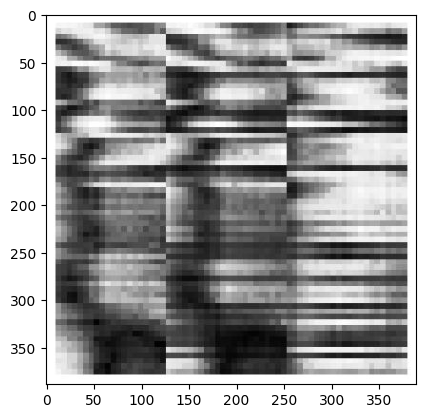

In [ ]:
# References: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
DATADIR = r"C:\Users\New Asus\Documents\FIT4701_2025_Sem1\training_img_dataset\front_dataset\front_baseline_macro\training"

CATEGORIES = ["jump", "nopeople", "squatting", "standing", "twist"]

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it

        break  # we just want one for now so break
    break  #...and one more!
 

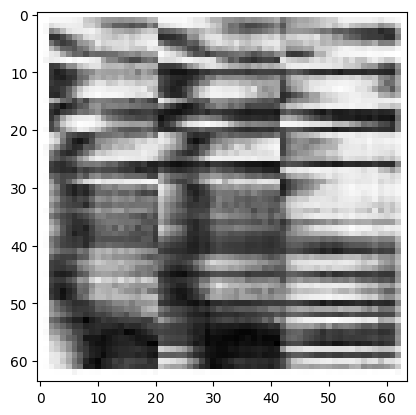

In [ ]:
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 1170/1170 [00:01<00:00, 975.50it/s]

6001


In [17]:
import random

random.shuffle(training_data)

In [18]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)  # Convert y to NumPy array

[[[[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [251]
   [209]
   ...
   [150]
   [192]
   [255]]

  [[255]
   [249]
   [156]
   ...
   [ 82]
   [150]
   [255]]

  ...

  [[255]
   [254]
   [250]
   ...
   [105]
   [169]
   [255]]

  [[255]
   [255]
   [254]
   ...
   [254]
   [251]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]]]


In [19]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [20]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [21]:
X = X/255.0
y = to_categorical(y, num_classes=5)

In [22]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [23]:
cnn.compile(  loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
cnn.fit(X, y, epochs=10, validation_split=0.1)

Epoch 1/10
169/169 [==============================] - 16s 20ms/step - loss: 0.9684 - accuracy: 0.5893 - val_loss: 0.5945 - val_accuracy: 0.8070
Epoch 2/10
169/169 [==============================] - 1s 7ms/step - loss: 0.4874 - accuracy: 0.8135 - val_loss: 0.3881 - val_accuracy: 0.8519
Epoch 3/10
169/169 [==============================] - 1s 7ms/step - loss: 0.3472 - accuracy: 0.8763 - val_loss: 0.2998 - val_accuracy: 0.8835
Epoch 4/10
169/169 [==============================] - 1s 7ms/step - loss: 0.2596 - accuracy: 0.9111 - val_loss: 0.2928 - val_accuracy: 0.8935
Epoch 5/10
169/169 [==============================] - 1s 7ms/step - loss: 0.2091 - accuracy: 0.9289 - val_loss: 0.2291 - val_accuracy: 0.9151
Epoch 6/10
169/169 [==============================] - 1s 7ms/step - loss: 0.1585 - accuracy: 0.9467 - val_loss: 0.2978 - val_accuracy: 0.8835
Epoch 7/10
169/169 [==============================] - 1s 7ms/step - loss: 0.1167 - accuracy: 0.9615 - val_loss: 0.2908 - val_accuracy: 0.9052
Epoc